In [ ]:
!pip install jieba
import pandas as pd
import jieba

# Load your CSV file
weibo_df = pd.read_csv('weibo_senti_100k_utf8_filtered.csv')

jieba.load_userdict("emoji_slang.txt")

# Define a function to segment text
def segment_text(text):
    return ' '.join(jieba.cut(text, cut_all=False))

# Apply the text segmentation function to the 'review_cleaned' column
weibo_df['review_cutted_project'] = weibo_df['review_cleaned'].apply(segment_text)

# Save the DataFrame back to CSV
weibo_df.to_csv('weibo_senti_100k_utf8_filtered_processed.csv', index=False)


Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
DEBUG:jieba:Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.993 seconds.
DEBUG:jieba:Loading model cost 0.993 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.


In [ ]:
weibo_df['review_cutted_project'][:10]

0         更博 了 爆照 了 帅 的 呀 就是 越来越 爱 你 生快 傻 缺爱 你 爱 你 爱 你
1      土耳其 的 事要 认真对待 哈哈 否则 直接 开除   很 是 细心 酒店 都 全部 OK 啦
2                                姑娘 都 羡慕 你 呢 还有 招财猫 高兴
3                                                 美爱 你
4                               梦想 有 多 大 舞台 就 有 多 大 鼓掌
5                                         花心 鼓掌   春暖花开
6    某 问答 社区 上 收到 一 大学生 发给 我 的 私信 偶 喜欢 阿姨 偶是 阿姨 控 我...
7    吃货 们 无不 啧啧称奇 好 不 喜欢 PS 写错 一个 字 哈哈                
8    Sweet   MorningFrom   now   onlove   yourselfe...
9    霍思燕 剖腹产 下小江江   老公 落泪 今晨 9 时 霍思燕 产下 一名 男婴 宝宝 重 ...
Name: review_cutted_project, dtype: object

In [ ]:
!pip install tensorflow keras sklearn jieba

import pandas as pd
import jieba
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout, Attention, Lambda
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.utils.class_weight import compute_class_weight

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
# Load the data
weibo_df = pd.read_csv('weibo_senti_100k_utf8_filtered_processed.csv')

# Segment text with jieba
weibo_df['review_cutted_project'] = weibo_df['review_cleaned'].apply(lambda x: ' '.join(jieba.cut(x)))

# Prepare X and y
X = weibo_df['review_cutted_project'].values
y = weibo_df['sentiment_classified'].apply(lambda x: 1 if x == 1 else 0).values  # Convert -1/1 to 0/1

# Tokenize and pad sequences
tokenizer = Tokenizer(num_words=20000)  # Adjust num_words to the size of your vocabulary
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
X_pad = pad_sequences(X_seq, maxlen=100)  # Adjust maxlen to the length that makes sense for your data

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.2, random_state=42)

In [ ]:
from imblearn.over_sampling import SMOTE

# Resampling with SMOTE
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)
class_weights_dict = dict(enumerate(class_weights))

In [ ]:
class_weights_dict

{0: 1.0, 1: 1.0}

In [ ]:
from collections import Counter

class_distribution_before = Counter(y_train)

# Display the class distribution
print("Class distribution after before SMOTE:", class_distribution_before)

# Optionally, you can calculate and display the ratio
total_samples = sum(class_distribution_before.values())
class_ratios = {cls: count / total_samples for cls, count in class_distribution_before.items()}

print("Class ratios after before SMOTE:", class_ratios)

# Count the occurrences of each class in the resampled dataset
class_distribution = Counter(y_train_resampled)

# Display the class distribution
print("Class distribution after applying SMOTE:", class_distribution)

# Optionally, you can calculate and display the ratio
total_samples = sum(class_distribution.values())
class_ratios = {cls: count / total_samples for cls, count in class_distribution.items()}

print("Class ratios after applying SMOTE:", class_ratios)


Class distribution after before SMOTE: Counter({1: 58271, 0: 21150})
Class ratios after before SMOTE: {1: 0.7336976366452198, 0: 0.26630236335478025}
Class distribution after applying SMOTE: Counter({1: 58271, 0: 58271})
Class ratios after applying SMOTE: {1: 0.5, 0: 0.5}


In [ ]:
# Parameters for the model (adjust these to suit your data)
max_features = 20000  # Adjust to the size of your vocabulary
maxlen = 100          # Adjust to the length that makes sense for your data
embedding_dim = 128
lstm_units = 64

# Model building
input_layer = Input(shape=(maxlen,))
embedding_layer = Embedding(max_features, embedding_dim, input_length=maxlen)(input_layer)
bilstm_layer = Bidirectional(LSTM(lstm_units, return_sequences=True))(embedding_layer)
attention_layer = Attention()([bilstm_layer, bilstm_layer])
lambda_layer = Lambda(lambda x: K.mean(x, axis=1))(attention_layer)
dense_layer = Dense(64, activation='relu')(lambda_layer)
dropout_layer = Dropout(0.5)(dense_layer)
output_layer = Dense(1, activation='sigmoid')(dropout_layer)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 100, 128)             2560000   ['input_1[0][0]']             
                                                                                                  
 bidirectional (Bidirection  (None, 100, 128)             98816     ['embedding[0][0]']           
 al)                                                                                              
                                                                                                  
 attention (Attention)       (None, 100, 128)             0         ['bidirectional[0][0]',   

In [ ]:
# Fit the model with class weights
model.fit(X_train_resampled, y_train_resampled, batch_size=64, epochs=1, validation_split=0.1)

3278/3278 [==============================] - 88s 23ms/step - loss: 0.4556 - accuracy: 0.7810 - val_loss: 0.5844 - val_accuracy: 0.7214


In [ ]:
# Predict on the test set
y_pred = model.predict(X_test)

# Threshold predictions to binary
y_pred_thresh = (y_pred > 0.5).astype(int)

# Calculate precision, recall, and F1-score for each class
report = classification_report(y_test, y_pred_thresh, target_names=['Negative', 'Positive'])
print(report)

621/621 [==============================] - 4s 6ms/step
              precision    recall  f1-score   support

    Negative       0.72      0.83      0.77      5218
    Positive       0.93      0.89      0.91     14638

    accuracy                           0.87     19856
   macro avg       0.83      0.86      0.84     19856
weighted avg       0.88      0.87      0.87     19856



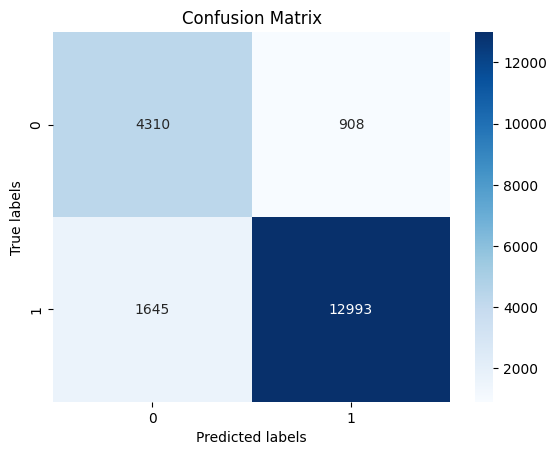

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_thresh)

# Plot the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
